In [1]:
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:', device)

Using device: cuda

In [3]:
transform = transforms.Compose([transforms.Resize(64), transforms.CenterCrop(64), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:


class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image
     


In [5]:
ds = Faces(folder='cropped_faces/')

In [6]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Define the Discriminator Architecture
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=128,out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
        # apply weights
        self.apply(weights_init)
        
    def forward(self, x):
        return self.model(x)

In [9]:
# Discriminator summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [10]:
class Generator(nn.Module):
    def __init__(self):
        
        # Define the Generator Architecture
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
        self.apply(weights_init)
        
    def forward(self, x):
        return self.model(x)

In [11]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [12]:
def discriminatorTrainStep(realData,fakeData):
    d_optimizer.zero_grad()
    predictionReal = discriminator(realData)
    errorReal = loss(predictionReal.squeeze(), torch.ones(len(realData)).to(device))
    errorReal.backward()
    
    predictionFake = discriminator(fakeData)
    errorFake = loss(predictionFake.squeeze(), torch.zeros(len(fakeData)).to(device))
    errorFake.backward()
    
    d_optimizer.step()  
    return errorReal + errorFake

In [13]:
def generatorTrainStep(fakeData):
    g_optimizer.zero_grad()
    prediction = discriminator(fakeData)
    error = loss(prediction.squeeze(), torch.ones(len(fakeData)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [14]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

loss = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [15]:
class Report:
    def __init__(self, num_epochs):
        self.num_epochs = num_epochs
        self.dLoss = []
        self.gLoss = []
        self.epochs = []  # Add this line to initialize epochs list
        self.current_epoch = 0

    def record(self, epoch, dLoss, gLoss, **kwargs):
        self.dLoss.append(dLoss)
        self.gLoss.append(gLoss)
        if epoch not in self.epochs:  # Add unique epoch
            self.epochs.append(epoch)

    def report_avgs(self, epoch):
        self.current_epoch = epoch

    def plot_epochs(self):
        # Existing plotting code...
        pass


In [16]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm
import pandas as pd  # Import pandas for saving data to CSV

num_epochs = 2
# Initialize lists to store losses for each epoch
all_d_losses = []  # To store all discriminator losses for each epoch
all_g_losses = []  # To store all generator losses for each epoch

for epoch in range(num_epochs):
    epoch_d_losses = []  # To store discriminator losses for the current epoch
    epoch_g_losses = []  # To store generator losses for the current epoch
    
    # Use tqdm to create a progress bar for the dataloader
    with tqdm(total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
        for i, images in enumerate(dataloader):
            # real images
            realData = images.to(device)
            
            # Generate Fake images
            fakeData = generator(torch.randn(len(realData), 100, 1, 1).to(device)).to(device)
            fakeData = fakeData.detach()
            
            # Train the Discriminator
            dLoss = discriminatorTrainStep(realData, fakeData)
            
            # Generate Fake images
            fakeData = generator(torch.randn(len(realData), 100, 1, 1).to(device)).to(device)
            gLoss = generatorTrainStep(fakeData)
            
            # Store the loss values for the current epoch
            epoch_d_losses.append(dLoss.item())
            epoch_g_losses.append(gLoss.item())
            
            # Update the progress bar
            pbar.set_postfix({'dLoss': dLoss.item(), 'gLoss': gLoss.item()})
            pbar.update(1)  # Increment the progress bar

    # Save losses for the current epoch to the overall lists
    all_d_losses.append(sum(epoch_d_losses) / len(epoch_d_losses))  # Average discriminator loss
    all_g_losses.append(sum(epoch_g_losses) / len(epoch_g_losses))  # Average generator loss

    # Save a grid of generated images
    with torch.no_grad():
        fakeData = generator(torch.randn(100, 100, 1, 1).to(device)).to(device)  # Generate a batch of fake images
        grid = vutils.make_grid(fakeData.detach(), nrow=10, normalize=True)  # Create a grid
        vutils.save_image(grid, f'EpochImages/epoch_{epoch + 1}_images.png')  # Save the grid of images

# Save the average losses for each epoch to a CSV file
loss_data = pd.DataFrame({
    'Epoch': list(range(1, num_epochs + 1)),
    'Discriminator Loss': all_d_losses,
    'Generator Loss': all_g_losses
})
loss_data.to_csv('losses_per_epoch.csv', index=False)  # Save to CSV

# Plot the losses using matplotlib
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), all_d_losses, label='Discriminator Loss', color='red', marker='o')
plt.plot(range(1, num_epochs + 1), all_g_losses, label='Generator Loss', color='blue', marker='o')
plt.title('Average Losses Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))  # Set x-ticks to match the number of epochs
plt.legend()
plt.show()

#save this plot
plt.savefig('losses_per_epoch.png')

# save the model
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


Epoch 1/2:   2%|▏         | 11/448 [00:01<00:43,  9.97it/s, dLoss=0.16, gLoss=7.4] 


KeyboardInterrupt: 

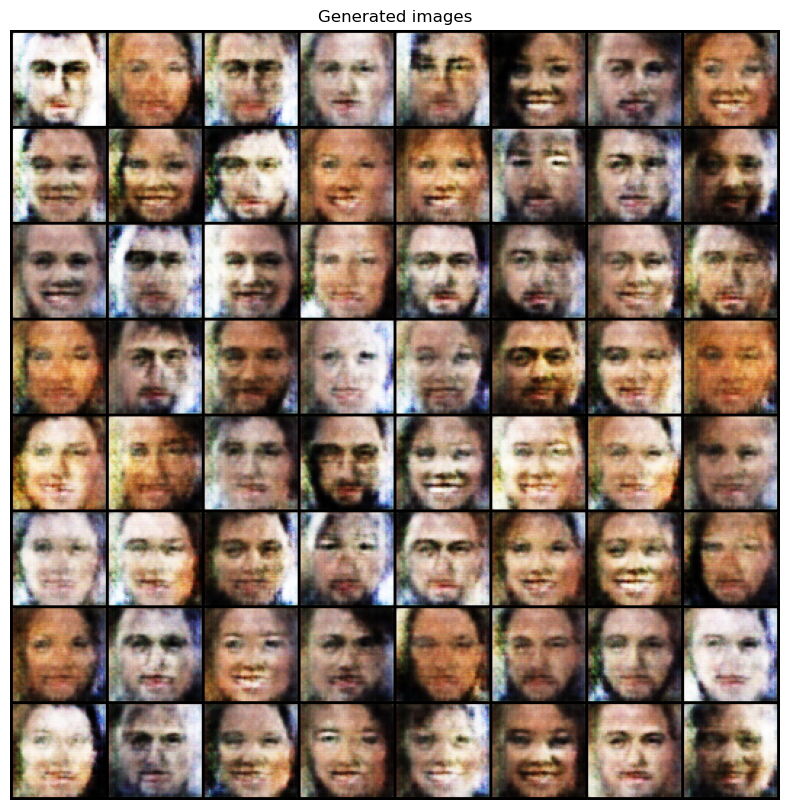

In [71]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')